In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os
from tkinter import Tk
from tkinter.filedialog import askopenfilenames, asksaveasfilename
from scipy.ndimage import median_filter


In [2]:

# Prompt the user to select input filess
root = Tk()
root.withdraw()  # Hide the main window
root.attributes("-topmost", True)  # Bring the dialog to the front
file_paths = askopenfilenames(
    title="Select TIFF files to average",
    filetypes=[("TIFF files", "*.tif"), ("All files", "*.*")]
)
root.update()  # Update to make sure the selection goes through

if not file_paths:
    print("No files selected. Exiting.")
    exit()

# Load all files into a 3D array to calculate pixel-by-pixel statistics and extract metadata
data_stack = []
metadata = None

for file_path in file_paths:
    with rasterio.open(file_path) as src:
        data = src.read(1)  # Read the first (or only) band of the TIFF
        data_stack.append(data)
        
        # Extract metadata from the first file
        if metadata is None:
            metadata = src.meta.copy()

# Convert the list of arrays to a 3D numpy array (stacked along the third dimension)
data_stack = np.stack(data_stack, axis=2)


In [9]:

# Set default percentile threshold
percentile_threshold = 95  # User can edit this value as needed


Text(0.5, 1.0, 'Raw threshold')

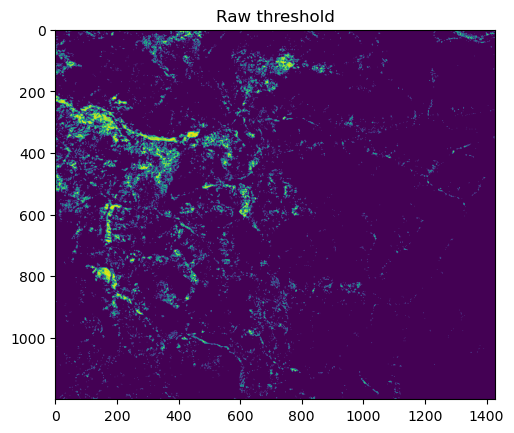

In [10]:

# Calculate pixel-by-pixel statistics
average_array = np.mean(data_stack, axis=2)
min_array = np.min(data_stack, axis=2)
max_array = np.max(data_stack, axis=2)
std_dev_array = np.std(data_stack, axis=2)

# Calculate CV map (handling division by zero where mean is zero)
cv_array = np.divide(std_dev_array, average_array, out=np.zeros_like(std_dev_array), where=average_array != 0)

# Calculate the threshold value based on the set percentile threshold
threshold_value = np.percentile(average_array, percentile_threshold)

# Create a thresholded array with values below the threshold set to zero
thresholded_array = np.where(average_array >= threshold_value, average_array, 0)

plt.imshow(thresholded_array)
plt.title('Raw threshold')


Text(0.5, 1.0, 'Smoothed threshold')

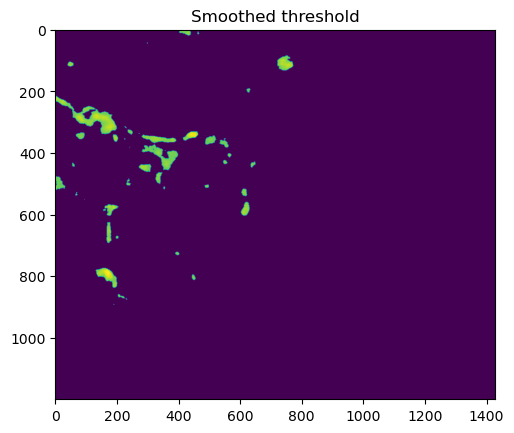

In [11]:
# Apply median filter to the thresholded array
window_size = 20  # Adjust window size as needed for smoothing
smoothed_array = median_filter(thresholded_array, size=window_size)

plt.imshow(smoothed_array)
plt.title('Smoothed threshold')


In [ ]:

# Prompt the user to select the output file path and name
output_file = asksaveasfilename(
    title="Save Averaged Probability Map as TIFF",
    defaultextension=".tif",
    filetypes=[("TIFF files", "*.tif"), ("All files", "*.*")]
)

if not output_file:
    print("No output file selected. Exiting.")
    exit()

# Define output directory and base filename
output_dir = os.path.dirname(output_file)
base_name = os.path.splitext(os.path.basename(output_file))[0]

# Save pixel-by-pixel statistics as separate TIFF files
def save_array_as_tiff(array, filename, metadata):
    # Update the metadata to reflect the data type and single band
    metadata.update({
        "dtype": rasterio.float64,
        "count": 1
    })

    # Save the array as a GeoTIFF with the updated metadata
    with rasterio.open(filename, "w", **metadata) as dst:
        dst.write(array, 1)

# Save averaged probability map as TIFF
save_array_as_tiff(average_array, output_file, metadata)
print(f"Averaged probability map saved as '{output_file}'")

# Save raw thresholded map as TIFF
thresholded_file_path = os.path.join(output_dir, f"{base_name}_thresholded_{int(percentile_threshold)}th_percentile.tif")
save_array_as_tiff(thresholded_array, thresholded_file_path, metadata)
print(f"Raw thresholded map saved as '{thresholded_file_path}'")

# Save smoothed, thresholded map as TIFF
smoothed_file_path = os.path.join(output_dir, f"{base_name}_smoothed_thresholded_{int(percentile_threshold)}th_percentile.tif")
save_array_as_tiff(smoothed_array, smoothed_file_path, metadata)
print(f"Smoothed thresholded map saved as '{smoothed_file_path}'")

# Save min, max, std deviation, and CV as separate TIFF files
min_tiff_path = os.path.join(output_dir, f"{base_name}_min.tif")
max_tiff_path = os.path.join(output_dir, f"{base_name}_max.tif")
std_dev_tiff_path = os.path.join(output_dir, f"{base_name}_std_dev.tif")
cv_tiff_path = os.path.join(output_dir, f"{base_name}_cv.tif")

save_array_as_tiff(min_array, min_tiff_path, metadata)
save_array_as_tiff(max_array, max_tiff_path, metadata)
save_array_as_tiff(std_dev_array, std_dev_tiff_path, metadata)
save_array_as_tiff(cv_array, cv_tiff_path, metadata)

print(f"Min map saved as '{min_tiff_path}'")
print(f"Max map saved as '{max_tiff_path}'")
print(f"Standard deviation map saved as '{std_dev_tiff_path}'")
print(f"Coefficient of Variation (CV) map saved as '{cv_tiff_path}'")

# Plot the smoothed, thresholded probability map
plt.figure(figsize=(14, 10))
plt.imshow(smoothed_array, cmap='viridis')
plt.colorbar(label='Probability')
plt.title('Smoothed Mineral Deposit Probability Map', fontsize=15)
plt.axis('off')
plt.tight_layout()

# Save the plot as a PNG file with the same name as the output TIFF
png_file_path = smoothed_file_path.replace(".tif", ".png")
plt.savefig(png_file_path, format='png')
print(f"Smoothed thresholded map image saved as '{png_file_path}'")

plt.show()
